In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Industry problem solving example: vehicle routing problem with time windows

In this module we will see how we can solve a well known integer programming model with a hybrid approach 
that utilizes classical and quantum computers. 
The vehicle routing problem with time windows (VRPTW) is defined as follows. 

Suppose that we have an unlimited number of vehicles $K$ with capacity $c_k$ for $k \in K$, and a set of customers $V$, each having a demand $d_i$ and a delivery time window $(\tau_i^b,\tau_i^e)$ for $i \in V$. 
All vehicles are stationed in a single depot, where they start and end their day. Utilizing a vehicle incurs a fixed cost $f$, while driving the vehicle incurs a mileage cost of $m$ (\\$ /mile) and a driver cost of $h$ (\\$ /hr). 
Each vehicle can satisfy a subset of the customer demand. 
A solution to our problem consists of the number of vehicles we use, and the route listing the customers being visited in order  for each vehicle. 
A solution satisfies the following requirements:
* Each customer is serviced by one and only one vehicle.
* Each delivery is done within the customer time window.
* Each vehicle leaves and returns to the depot only once, i.e., no vehicle reloads.
* There a service time $s_i$ for the delivery at customer $i \in V$.

The optimal solution to the problem achieves the minimum cost as defined by the sum of the fixed, mileage, and hourly costs. 

Below we formulate a simplified version of this problem as mixed integer programming model. In particular, without loss of generality, we assume:
* All vehicles have the same capacity $C$.
* All customers have the same demand $d_i=1$ for all $i \in V$.
* All customers require the same service time $s_i=\sigma$ for all $i \in V$.
* All customers have the same time window, say 8am to 8 pm.

### Parameters
Let:
* $V=\{1,\ldots,n\}$ be the set of all customers.
* $d$ denote the depot where all vehicles start and end their day.
* $N=V \cup \{d\}$
* $K$ be the set of all vehicles.
* $C$ be the capacity of the vehicles.
* $\tau_{ij}$ be the travel time from $i$ to $j$, where $i,j \in N$.
* $\sigma$ be the service time at customer; equal to 2 min for all customers.
* $d_{ij}$ be the travel distance from $i $to $j$, where $i,j \in N$.
* $f$ be the cost for putting a vehicle in service.
* $h$ be the cost per hour of driving.
* $m$ be the cost per mile of driving.

### Variables
We define the following variables:
$$x_{ij}^k=  \left\{ \begin{array}{rl}  
        1 &  \text{if vehicle $k$ goes from customer $i$ to customer $j$}\\
        0 & \text{otherwise} 
                     \end{array} \right.
$$                     
$$y^k=\left \{ \begin{array}{rl} 
        1 & \text{if vehicle $k$ is in service} \\
        0 & \text{otherwise}
                     \end{array} \right.
$$                                 
$$ t_i^k: \text{time when vehicle $k$ arrives at location $i$}$$

### Constraints
* Each vehicle if used must leave the depot
  $$\sum_{j \in V} x_{dj}^k = y^k \quad \quad \forall k \in K$$
* Each vehicle if used must return to the depot
  $$\sum_{i \in V} x_{id}^k = y^k \quad \quad \forall k \in K$$  
* Each vehicle if used can serve customers up to its capacity   
  $$\sum_{i \in V, j \in V, j \neq i} x_{ij}^k \le C y^k \quad \quad \forall k \in K$$
* Every customer must be served by exactly one vehicle (there must be a next destination for the vehicle)
  $$\sum_{k \in K} \sum_{j \in V, j \neq i} x_{ij}^k = 1 \quad \quad \forall i \in V$$
* Each customer request has to be served (there must be a vehicle coming to the customer) 
  $$\sum_{k \in K} \sum_{i \in N, i \neq j} x_{ij}^k = 1 \quad \quad \forall j \in V$$
* Each customer request must be served between 8am and 8pm. If time starts at 8am and $t_j^k$ is in seconds then  
  $$0 \le t_j^k \le 43200 $$
* If a vehicle $k$ goes from customer $i$ to customer $j$, the vehicle cannot be at customer $j$ before the time it was at customer $i$, which is $t_i^k$ plus the time it took to service customer $i$, which is $\sigma$ and the time to drive from that location to the pick up location of customer $j$, which is $\tau_{ij}$. The same holds for the depot for the return. This is an indicator constraint, that is, it applies only when the vehicle $k$ is used to go from $i$ to $j$, i.e.,  $x_{ij}^k=1$.
$$t_j^k \geq (t_i^k+\tau_{ij}+\sigma) x_{ij}^k \quad \quad \forall \ \ k \in K,i \in V,j \in N$$




## Objective
The objective function is to minimize the total cost which consists of the following components:
* Cost of using the vehicles:
$$f \sum_k y^k $$
* Cost for driving the vehicles the total distance:
$$ m \sum_{k} \sum_{i,j \in N, i \neq j} d_{ij} x_{ij}^k$$
* Cost of paying the driver for hours driven:
$$ h \sum_{k \in K} t_d^k$$
and thus the objective is 
$$\min f \sum_k y^k + m \sum_{k} \sum_{i,j \in N, i \neq j} d_{ij} x_{ij}^k+h \sum_{k \in K} t_d^k$$

This problem can be formulated in CPLEX and solved for small instances to optimality. However, depending on the data, instances with more than 10 delivery locations start taking a considerable amount of time and memory, making the optimization of this problem for real life situations prohibitively expensive. Moreover, these problems need to be solved within an hour or so in practice so a good quality solution is what one usually settles for.  The number of variables are given by $|N|(|N|-1)|K|+|N||K|+|K|=|N|^2|K|-|N||K|+|N||K|+|K|=|K|(|N|^2+1)$. So for example, if we have 1200 delivery locations and start with 15 vehicles available we have over 20 million variables.

## Limitations of current classical approaches

Given the inability to solve these problems to optimality within available time and memory resources with the above approach, heuristic algorithms are applied in real world situations. These heuristics can provide "good" solutions in very short times, but they do not provide any information on the quality of the particular solution. Because for large scale problems even small improvements in the routing can result in significant gains, having such information is important. Quantum computing has the potential to help find better solutions and/or solve larger instances within a given time frame. 

## Quantum computing
A typical quantum approach would be to transform the mathematical programming formulation given above to a QUBO and use one of the available hybrid algorithms suchs QAOA or VQE to solve that QUBO. However, this approach has major setback: the variables $t_i^k$ are general integers and need to be converted to binary for the QUBO representation of the problem. Given the size of the integer values, this conversion can result in significant increases in the number of binary variables in the QUBO and thus in the number of qubits of the quantum computer. Having already 20 million variables for the small/medium size problem above, this conversion will add several million binary variables (the exact number, of course, depends on the time windows and the values the $t$ variables can take).

## A different quantum approach

Here we present a different approach based on decomposing the problem. The main idea is shown in the diagram below for a small example.
<div>
<img src='VRP_approach_qa.png'>
</div>




The approach is as follows: if we were able to generate many feasible solutions (i.e., solutions that satisfy all constraints) then we can have a list of many feasible routes. Each solution consists of one or more routes corresponding to the number of vehicles used.
In the left side of the diagram, we see four different solutions to a problem with 5 delivery locations and the depot `D`. Each of the first three solutions contains two routes (i.e., uses two vehicles), while the fourth solution contains three routes. Thus we have generated 4 solutions, which have 9 routes. The list of all unique routes consists of the routes shown in the green box in the diagram. Each of these routes has a cost associated with it. Now we are left with the problem of finding the minimum cost subset of these routes that "cover" each delivery location, i.e., each delivery location appears in exactly one of the selected routes. This is known as the exact set covering problem (or set partitioning problem) and is a 0-1 (binary) problem which can be solved with a hybrid quantum algorithm such as QAOA or VQE. The number of qubits needed is the same as the number of variables, which is the number of unique routes.

In the following, we will demonstrate this approach in a small example. 



## An example of VRP with 9 delivery points and a single depot

Here we demonstrate the main idea of the hybrid approach with a small example. The problem consists of a single depot and 9 delivery points. 

First we import the necessary packages, including `cplex`. If `cplex` is not available, we can skip to the part of the notebook after the routes have been generated and read the routes from a file.  

In [1]:
import random
import cplex
from cplex.exceptions import CplexSolverError, error_codes
import pandas as pd
import time
import numpy as np

The following are the constants (data) of the problem:
* `fc` is the fixed cost for using a vehicle.
* `mc` is the cost per km driven (\$20 cents per km; our variables are in meter so we divide by 1000).
* `tc` is the cost per hour driven (\$17 per hour; our variables are in seconds so we divide by 3600).
* `tl` is the time window (2 hours from the time vehicle leaves the depot until it returns).
* `C` is the vehicle capacity.


In [2]:
##### Constant parameters
fc=33
mc=.2/1000
tc=17/3600
sigma=120
tl=2*3600
C=4

The file `VRP10_data.npy` contains two `numpy` arrays with distance and driving time between any two nodes in the network. The following code reads these data into two arrays `d` and `tau`.

In [3]:
with open('VRP10_data.npy', 'rb') as f:
    d = np.load(f)
    tau = np.load(f)


`S` is the set of delivery points. We assume that node `1` is the depot so the delivery points are nodes `2` to `10`.

In [4]:
S=[i+1 for i in range(1,10)]
S

[2, 3, 4, 5, 6, 7, 8, 9, 10]

The following are auxiliary functions:
* `calculate_cost` takes a route as input and returns the total visits, time, and distance
* `calculate_total_cost` takes a list of routes as input and returns the total cost
* `get_routes` takes the `x` variables solution from `cplex` as input and returns a list of routes corresponding to the solution
* `get_solution_arcs` takes a solution from `cplex` as input and returns a list of arcs and a list of routes corresponding to the solution

In [5]:
def calculate_cost(path):
    cap=0
    dist=0
    ttime=0
    ptimes=[]
    for i in range(0,len(path)-1):
        ttime=ttime+tau[path[i]][path[i+1]]+sigma
        dist=dist+d[path[i]][path[i+1]]
        cap=cap+1
    return cap-1,ttime-sigma,dist
    
def calculate_total_cost(paths):
    tcost=0
    ttime=0
    tdist=0
    for i in paths:
        ttime=ttime+paths[i][len(paths[i])-1][1]
        tdist=tdist+paths[i][len(paths[i])-1][2]
        #print(tcost,ttime,tdist)
    return fc*len(paths)+tc*ttime+mc*tdist


def get_routes(x,prt=False):
    paths=[]
    nbt=len(K)
    nall=len(N)
    nbc=nall-1
    pkstep=nbc*nall
    pt=nbt+pkstep*(nbt)

    for k in K:
        nxt={}
        if (x[k-1] >0):
            pk=nbt+pkstep*(k-1)
            for i in N:
                for j in N:
                    if i !=j: 
                        v=x[pk+((i-1)*nbc+j-2 if i < j else (i-1)*nbc+j-1)]
                        if v>0:
                            nxt[i]=j
            q=0
            i=1
            dst=0.0
            path=[1]
            while (q< len(nxt)):
                dst=dst+d[P[i-1]][P[nxt[i]-1]]
                atm=x[pt+nall*(k-1)+nxt[i]-1]
                path.append(P[nxt[i]-1])
                i=nxt[i];
                q=q+1
            pobj=tc*atm+mc*dst.item()
            path_s=path.copy()
            path_s.sort()
            pss=[str(x) for x in path_s[2:]]
            pss="".join(pss)
            paths.append((path,atm,dst.item(),pobj,pss))
    if prt: print(paths)
    return paths

def get_solution_arcs(solution,prt=False):
    arcs=[]
    paths={}
    nbt=len(K)
    nall=len(N)
    nbc=nall-1
    pkstep=nbc*nall

    pt=nbt+pkstep*(nbt)

    for k in K:
        nxt={}
        if (solution.get_values(k-1) >0):
            pk=nbt+pkstep*(k-1)
            for i in N:
                for j in N:
                    #print(k,pk,pt,i,j)
                    if i !=j: 
                        v=solution.get_values(pk+((i-1)*nbc+j-2 if i < j else (i-1)*nbc+j-1))
                        if v>0:
                            arcs.append((i,j))
                            nxt[i]=j
            q=0
            i=1
            dst=0.0
            path=[(1,0,0)]
            while (q< len(nxt)):
                dst=dst+d[P[i-1]][P[nxt[i]-1]]
                atm=solution.get_values(pt+nall*(k-1)+nxt[i]-1)
                path.append((P[nxt[i]-1],atm,dst.item()));
                i=nxt[i];
                q=q+1
            #print(path)
            paths[k]=path
    if prt: print(paths)
    return arcs,paths



A  heuristic algorithm that provides a solution to the problem is needed so one can get a good bound on the number of vehicles needed. Clearly one vehicle per delivery is a solution too, but that creates too many variable. So by restricting the number of available vehicles, we can reduce the size of the problem. Below we give such a naive heuristic. 

In [6]:
def get_best_random_solution(S, C, tau, sigma, d, fc, mc, tc, bobj=1000000,tries=1000,print_detail=False):
    #generate 'tries' random feasible routes
    for i in range(0,tries):
        k=1
        tk=0
        prev=1
        R=S.copy()
        random.shuffle(R)
        i=0
        rc=0
        path=[prev]
        pdist=0
        ptime=0
        wpaths=[]
        while len(R) >=1:
            if R[i]!= prev: 
                tk=tk+tau[prev][R[i]] # Time to reach R[i]
                rc=rc+1
            if ((rc <= C) & (tk+sigma+tau[R[i]][1] <= tl)): ## Has capacity and time to serve the client and return to depot
                pdist=pdist+d[prev][R[i]]
                tk=tk+sigma # Serve the client
                path.append(R[i])
                prev=R[i]
            else: ## Exceeded capacity or time to return to depot
                # Go back to depot
                pdist=pdist+d[prev][1]
                ptime=ptime+tk-tau[prev][R[i]]+tau[prev][1]
                path.append(1)
                wpaths.append(path)
                # New vehicle
                k=k+1 
                # Starts at the depot with the current client we couldn't add
                path=[1]
                tk=tau[1][R[i]]+sigma
                rc=1
                pdist=pdist+d[1][R[i]]
                path.append(R[i])
                prev=R[i]
            R.remove(R[i])
        path.append(1)
        wpaths.append(path)
        pdist=pdist+d[prev][1]
        ptime=ptime+tk+tau[prev][1]
        pcost=fc*k+pdist*mc+ptime*tc
        if (bobj > pcost ):
            bobj=pcost
            bpath=wpaths
            # mipstart=warmstart
            if (print_detail): print('Best obj: ',bobj,' with ',k, ' trucks.')
    print('Best obj: ',bobj,' with ',k, ' trucks.')
    return(bpath,bobj,len(bpath))

The function `solve_cplex_model` takes the problem parameters as input, generates a model in `cplex`, and uses the `cplex` optimization engine to solve the problem. We are not discussing how this is implemented, as it is out of scope for this presentation. If `cplex` is not available, we can read the solution from a file and continue with the quantum part of the algorithm. 

In [7]:
# Setup mdl
def solve_cplex_model(N,P,K,fc,mc,tc,C,tl,sigma,time_limit,heur=None,generate_routes=False):
    stime=time.time()
    mdl=cplex.Cplex()
    mdl.objective.set_sense(mdl.objective.sense.minimize)
    nall=len(N)
    nbc=nall-1
    nbt=len(K)
    nYvars=nbt
    nXvars=nbc*nall*nbt
    nTvars=nall*nbt
    print('Problem has {0} y variables, {1} x variables and {2} t variables'.format(nYvars,nXvars,nTvars))

    ## Y vehicle variables
    ycosts=[fc]*nYvars
    ynames=['y_'+str(k) for k in K ]
    ytypes=['B']*nYvars
    yind=list(mdl.variables.add(obj=ycosts,types=ytypes,names=ynames))
    
    ## X route variables
    xcosts=[mc*d[P[i-1]][P[j-1]] for k in K for i in N for j in N if i!=j ]
    xnames=['x_'+str(i)+'_'+str(j)+'_'+str(k) for k in K for i in N for j in N if i!=j ]
    xtypes=['B']*nXvars
    xind=list(mdl.variables.add(obj=xcosts,types=xtypes,names=xnames))

    ## T time variables
    tcosts=[0.0 for i in N for k in K]
    for k in K: 
        tcosts[nall*(k-1)]=tc 
    tnames=['t_'+str(i)+'_'+str(k) for k in K for i in N ]
    tubs=[tl]*nall*nbt
    tind=list(mdl.variables.add(obj=tcosts,ub=tubs,names=tnames))
    pk=nbt
    pkstep=nbc*nall
    pt=nbt+pkstep*(nbt)
    # Constraints
    for k in range(1,nbt+1):
        ind1=[k-1]
        val1=[-1]
        ind2=[k-1]
        val2=[-1]
        ind3=[k-1]
        val3=[-(C+1)]
        pk=nbt+pkstep*(k-1)
        for j in N:
            ind4=[]
            val4=[]
            if j >1:
                ind1.append(pk+j-2)
                val1.append(1)
                ind2.append(pk+(j-1)*nbc)
                val2.append(1)
                for i in N:
                    if (i != j) :
                        ind4.append(pk+((i-1)*nbc+j-2 if i < j else (i-1)*nbc+j-1))
                        val4.append(1)
                        ind4.append(pk+((j-1)*nbc+i-2 if j < i else  (j-1)*nbc+i-1))
                        val4.append(-1)
                mdl.linear_constraints.add(lin_expr=[cplex.SparsePair(
                                        ind=ind4,val=val4)],
                                 senses=['E'],
                                 rhs=[0])    
                mdl.indicator_constraints.add(lin_expr=[[pt+nall*(k-1)+j-1],[1]],#['t_'+str(j)+'_'+str(k)],[1]],
                                            sense='G',
                                            rhs=tau[1][P[j-1]],
                                            #indvar=mdl.variables.get_indices('x_1_'+str(j)+'_'+str(k)))
                                            indvar=pk+j-2)
            for i in N:
                if i != j:
                    ind3.append(pk+((i-1)*nbc+j-2 if i < j else (i-1)*nbc+j-1))
                    val3.append(1)
    
        mdl.linear_constraints.add(lin_expr=[cplex.SparsePair(
                                        ind=ind1,val=val1)],
                                 senses=['E'],
                                 rhs=[0])
        mdl.linear_constraints.add(lin_expr=[cplex.SparsePair(
                                        ind=ind2,val=val2)],
                                 senses=['E'],
                                 rhs=[0])    
        mdl.linear_constraints.add(lin_expr=[cplex.SparsePair(
                                        ind=ind3,val=val3)],
                                 senses=['L'],
                                 rhs=[0])    
        if (k < len(K)):
            mdl.linear_constraints.add(lin_expr=[cplex.SparsePair(ind=[k-1,k],val=[1,-1])],
                                senses=['G'],
                                rhs=[0])
    pk=nbt
    for i in N:
        if i >1 :
            ind5=[]
            val5=[]
            for j in N:
                if j!= i:
                    for k in K:
                        pk=nbt+pkstep*(k-1)
                        lind=pk+((i-1)*nbc+j-2 if i < j else  (i-1)*nbc+j-1)
                        ind5.append(lind)
                        val5.append(1)
                        mdl.indicator_constraints.add(
                                            lin_expr=[[pt+nall*(k-1)+j-1,pt+nall*(k-1)+i-1],[1,-1]],
                                            sense='G',
                                            rhs=tau[P[i-1]][P[j-1]]+sigma,
                                            indvar=lind)

            mdl.linear_constraints.add(lin_expr=[cplex.SparsePair(
                                        ind=ind5,val=val5)],
                                 senses=['E'],
                                 rhs=[1])    

    etime=time.time()
    print('Time to generate {0} clients with {1} trucks available: {2}'.format(nbc,nbt,etime-stime))
    # CPLEX parameters
    mdl.parameters.timelimit.set(time_limit*60)
    mdl.parameters.emphasis.mip.set(2)
    mdl.parameters.mip.limits.populate.set(50)

    # MIP starts
    mdl.MIP_starts.delete()
    if (heur != None):
        names=[]
        v=0
        for r in heur:
            v=v+1
            names.append('y_'+str(v))
            for i in range(0,len(r)-2):
                names.append('x_'+str(P.index(r[i])+1)+"_"+str(P.index(r[i+1])+1)+'_'+str(v))
            names.append('x_'+str(P.index(r[i+1])+1)+"_"+str(P.index(r[i+2])+1)+'_'+str(v))
        mdl.MIP_starts.add([names,[1]*len(names)],mdl.MIP_starts.effort_level.solve_MIP)

    froutes={}
    if (generate_routes):
        while (mdl.solution.pool.get_num() < 2):
            mdl.populate_solution_pool()
        numsol = mdl.solution.pool.get_num()
        best_of_set=[]
        for i in range(numsol):
            objval_i = mdl.solution.pool.get_objective_value(i)
            x_i = mdl.solution.pool.get_values(i)
            for r in get_routes(x_i):
                rset=r[-1]
                if (rset not in froutes):
                    froutes[rset]=r
                elif r[-2] < froutes[rset][-2] :
                    froutes[rset]=r
                else:
                    continue
    else:
        mdl.solve()
    arcs,paths=get_solution_arcs(mdl.solution)
    print('Cplex ended with:',mdl.solution.get_status_string(), mdl.solution.get_status())
    return paths,froutes

In [8]:
time_limit=240 # Give CPLEX time limit in minutes
best_solution={}
best_solution['ntrucks']=0
best_solution['distance']=0
best_solution['time']=0
best_solution['truck_cost']=0
best_solution['time_cost']=0
best_solution['distance_cost']=0
best_solution['total_cost']=0
ttruck=0
ttime=0
tdist=0
cl_all={}
start_time=time.time()
cl_solution={}
bp,bo,nt=get_best_random_solution(S,C,tau,sigma,d,fc,mc,tc,tries=1000,print_detail=False)
cur_time=time.time()
heu_time=cur_time-start_time
print('Heuristic found solution with',nt,' trucks and obj of ',bo,' in ',heu_time,' secs.')
P=[1]+S # Depot + 9 delivery locations
N = [(n) for n in range(1,len(P)+1)]
K = [(k) for k in range(1,nt+2)]
print(P)
print(N)
clpaths,froutes=solve_cplex_model(N,P,K,fc,mc,tc,C,tl,sigma,time_limit,generate_routes=True)
cplex_time=time.time()-cur_time
print('Cplex run time: ',cplex_time)
ctrucks=len(clpaths)
cl_solution['ntrucks']=ctrucks
ctime=0
cdist=0
for i in clpaths:
    ctime=ctime+clpaths[i][-1][1]
    cdist=cdist+clpaths[i][-1][2]
cl_solution['distance']=cdist
cl_solution['time']=ctime
cl_solution['paths']=clpaths



Best obj:  182.55419999999998  with  3  trucks.
Heuristic found solution with 3  trucks and obj of  182.55419999999998  in  0.06078600883483887  secs.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Problem has 4 y variables, 360 x variables and 40 t variables
Time to generate 9 clients with 4 trucks available: 0.012552738189697266
Version identifier: 22.1.1.0 | 2023-02-09 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Emphasis_MIP                            2
CPXPARAM_MIP_Limits_Populate                     50
CPXPARAM_TimeLimit                               14400

Populate: phase I 
Tried aggregator 2 times.
MIP Presolve modified 256 coefficients.
Aggregator did 144 substitutions.
Reduced MIP has 600 rows, 584 columns, and 2614 nonzeros.
Reduced MIP has 364 binaries, 0 generals, 0 SOSs, and 360 indicators.
Presolve time = 0.01 sec. (2.69 ticks)
Probing fixed 1 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.00 ticks)
Cover probing fixed 

Aggregator did 5 substitutions.
Reduced MIP has 592 rows, 571 columns, and 5120 nonzeros.
Reduced MIP has 356 binaries, 0 generals, 0 SOSs, and 355 indicators.
Presolve time = 0.01 sec. (2.44 ticks)
Tried aggregator 1 time.
Reduced MIP has 592 rows, 571 columns, and 5120 nonzeros.
Reduced MIP has 356 binaries, 0 generals, 0 SOSs, and 355 indicators.
Presolve time = 0.01 sec. (2.91 ticks)
Represolve time = 0.13 sec. (29.73 ticks)
  67812     0      137.9790    73      179.7894      Cuts: 18  1171049   17.80%
  67812     0      137.9815    78      179.7894      Cuts: 15  1171064   17.80%
  67812     0      137.9843    78      179.7894      Cuts: 14  1171074   17.80%
  67812     0      137.9846    79      179.7894      Cuts: 24  1171083   17.80%
  67812     0      137.9846    78      179.7894      Cuts: 18  1171088   17.80%
  67812     0      137.9975    75      179.7894   LiftProj: 6  1171097   17.80%
  67812     2      137.9975    75      179.7894      147.7897  1171097   17.80%
  69556

 555757 340654      165.9766    14      179.7894      157.7216  9066454   12.27%
 577690 353656      172.4858    12      179.7894      158.0625  9381200   12.08%
 599429 366463      169.8327    14      179.7894      158.3838  9689571   11.91%
 621063 379198      175.1396    17      179.7894      158.6947  9994967   11.73%
 642681 392499      175.3950    11      179.7894      158.9949 10330550   11.57%
 663666 403336      176.5205    10      179.7894      159.2995 10621692   11.40%
 684501 414785    infeasible            179.7894      159.5989 10934230   11.23%
 705211 426324      162.8682    23      179.7894      159.8771 11251403   11.08%
 725526 435828      176.3135     6      179.7894      160.1362 11514038   10.93%
 744696 446452      175.9288     6      179.7894      160.3896 11803108   10.79%
Elapsed time = 726.86 sec. (132893.88 ticks, tree = 283.04 MB, solutions = 7)
 765037 457947        cutoff            179.7894      160.6226 12114225   10.66%
 784690 468389      165.4757   

 2151208 852465    infeasible            179.7894      175.3738 29859217    2.46%
 2172578 850678      177.1661    14      179.7894      175.5303 30009741    2.37%
 2194466 848394      178.1190    12      179.7894      175.6806 30159855    2.29%
 2216406 846155      179.4096    17      179.7894      175.8344 30298733    2.20%
 2238607 842480        cutoff            179.7894      175.9877 30476531    2.11%
 2261565 839377      178.4413     6      179.7894      176.1430 30608151    2.03%
 2285219 834690    infeasible            179.7894      176.3093 30774253    1.94%
 2309142 830321        cutoff            179.7894      176.4754 30911977    1.84%
Elapsed time = 2086.60 sec. (476234.27 ticks, tree = 666.06 MB, solutions = 7)
 2333635 825340        cutoff            179.7894      176.6457 31051510    1.75%
 2358576 818721        cutoff            179.7894      176.8128 31207050    1.66%
 2383935 813021    infeasible            179.7894      176.9988 31329026    1.55%
 2409937 805550    

The solution is contained in the `clpaths` dictionary. We see below that the solution uses 3 vehicles. Vehicle 1 goes on the path along these nodes: 1->5->8->2->4->1. For each node, the accumulated time and distance are also reported. 

In [9]:
clpaths

{1: [(1, 0, 0),
  (3, 1294.0, 10607.0),
  (7, 2429.0, 20690.0),
  (6, 3181.0, 24781.0),
  (9, 4071.0, 31754.0),
  (1, 5509.0, 43234.0)],
 2: [(1, 0, 0),
  (5, 1291.0, 11776.0),
  (8, 2123.0, 20643.0),
  (2, 2837.0, 25452.0),
  (4, 3169.0, 27002.0),
  (1, 4953.0, 41693.0)],
 3: [(1, 0, 0), (10, 1090.0, 9153.0), (1, 2278.9999999999586, 18191.0)]}

The following code provides a summary for each vehicle and the overall costs. The total cost for the optimal solution is 179.7894 which is composed of 99 fixed cost, 60.1658 driving time cost and 20.6236 mileage cost.

In [10]:
ttruck=0
ttime=0
tdist=0

ctruck=len(clpaths)
ctime=0
cdist=0
for i in clpaths:
    ttime=ttime+clpaths[i][-1][1]
    tdist=tdist+clpaths[i][-1][2]
    print(i,ttime,tdist)
    ttruck=ttruck+1
trc=33*ttruck
tic=17*ttime/3600
dic=0.2*tdist/1000
obj=trc+tic+dic
print(ttruck,ttime,tdist,trc,tic,dic,obj)

1 5509.0 43234.0
2 10462.0 84927.0
3 12740.999999999958 103118.0
3 12740.999999999958 103118.0 99 60.16583333333314 20.623600000000003 179.78943333333314


`froutes` contains all the feasible routes generated. `cplex` has generated 247 different routes. Below we print the first one only. The keys are the delivery points served by the route and the value is a list containing the route in order (starting and ending at node `1`, the depot), the total time, the total distance, the cost of the route (not including the fixed cost of a vehicle), and the delivery points visited.

In [11]:
print(len(froutes))
froutes[next(iter(froutes))]

235


([1, 3, 7, 6, 9, 1], 5509.0, 43234.0, 34.661522222222224, '3679')

To formulate the exact cover problem, we only need the list of delivery points and the total cost. Since each route corresponds to a vehicle, we add the fixed cost `fc` to the route cost. 

Next we save the feasible routes to a `pickle` file so we can use the routes without rerunning `cplex`.

In [12]:
esc_data=[]
for k in froutes:
    dpts=froutes[k][0][1:-1]
    dcst=froutes[k][3]+fc
    esc_data.append([dpts,dcst])

In [13]:
import pickle
pickle.dump(esc_data, open( "feasible_routes.p", "wb" ) )

### Set covering formulation

So far we have used classical methods to generate several feasible routes. Each route corresponds to a vehicle. The routes were saved in a file so if `cplex` was not available to run the previous part of the notebook, we can start here by reading the routes file. 

In [14]:
import pickle
esc_data=pickle.load(open( "feasible_routes.p", "rb" ))
print('Loaded ',len(esc_data),' routes.')

Loaded  235  routes.


We are selecting a small set of 5 routes to demonstrate the integer program. The first of the selected routes serves delivery points 5,8,2,4 (in that order) and has a cost of 64.73.

In [15]:
cov_data=esc_data[:5]
cov_data

[[[3, 7, 6, 9], 67.66152222222223],
 [[5, 8, 2, 4], 64.72776666666667],
 [[10], 47.40014444444425],
 [[5, 8, 2, 3], 64.50347777777779],
 [[9, 6, 7, 4], 68.51624444444445]]

The code below generates the graph using `pygraphviz` and shows the 5 routes in different colors. NB: you need to install `graphviz` first and then `pygraphviz` to be able to run the following code. 

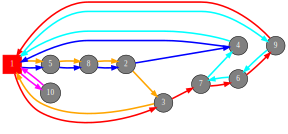

In [16]:
import pygraphviz as pgv

A = pgv.AGraph(directed=True, strict=False, rankdir="LR")
A.node_attr["shape"] = "circle"
A.node_attr["fillcolor"] = "grey"
A.node_attr["style"] = "filled"
A.node_attr["fontcolor"]= "white"
edge_colors=["red","blue","magenta","orange","cyan"]

A.edge_attr["penwidth"]=3
A.add_node(1, color="red",shape="square", fillcolor="red")
edgelist=[]
for n in S:
    A.add_node(n, color="black")
# add some edges
k=0
for p in cov_data:
    edges=[]
    edges.append((1,p[0][0]))
    for v in range(len(p[0])-1):
        edges.append((p[0][v],p[0][v+1]))
    edges.append((p[0][-1],1))
    edgelist.append(edges)
    A.add_edges_from(edges,color=edge_colors[k])
    k+=1
# adjust a graph parameter
A.graph_attr["epsilon"] = "0.001"
A.graph_attr["size"] = "4,6"
A.layout("dot")  # layout with dot
A.draw("routes.svg")  # write to file
from IPython.display import SVG
SVG('routes.svg')

We need to find the combination of routes that serve each delivery point exactly once and result in the minimum total cost. To demonstrate, we formulate this as an integer problem.  The variables $x_j \in \{0,1\}$ are assigned the value $1$ if route $R(j)$ is selected and $0$ otherwise. The constraints are defined for each delivery point $i$ and state that the delivery point must be served by exactly one route. For example, in the figure above, we cannot select the magenta and the cyan routes together because both serve location 10. 
$$\sum_{j: i \in R(j)} x_j = 1 \quad \quad \text{   for} \ i \in S$$

We are using the `docplex` package to formulate and solve this with `cplex`.

In [17]:
from docplex.mp.model import Model

In [18]:
qmdl=Model('exsetcov')
X=[j+1 for j in range(len(cov_data))]
qx=qmdl.binary_var_dict(X,name='route')
cnames=['node_'+str(i) for i in S]
qmdl.add_constraints((qmdl.sum(qx[j] for j in X if i in cov_data[j-1][0])==1 for i in S),cnames)
qmdl.minimize(qmdl.sum(cov_data[j-1][1]*qx[j] for j in X))
print(qmdl.export_as_lp_string())
qsol=qmdl.solve(log_output=True)
print(qsol)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: exsetcov

Minimize
 obj: 67.661522222222 route_1 + 64.727766666667 route_2
      + 47.400144444444 route_3 + 64.503477777778 route_4
      + 68.516244444444 route_5
Subject To
 node_2: route_2 + route_4 = 1
 node_3: route_1 + route_4 = 1
 node_4: route_2 + route_5 = 1
 node_5: route_2 + route_4 = 1
 node_6: route_1 + route_5 = 1
 node_7: route_1 + route_5 = 1
 node_8: route_2 + route_4 = 1
 node_9: route_1 + route_5 = 1
 node_10: route_3 = 1

Bounds
 0 <= route_1 <= 1
 0 <= route_2 <= 1
 0 <= route_3 <= 1
 0 <= route_4 <= 1
 0 <= route_5 <= 1

Binaries
 route_1 route_2 route_3 route_4 route_5
End

Version identifier: 22.1.1.0 | 2023-02-09 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 179.789433 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 6 rows and 2 columns.
Aggregator did 3 substitutions.
All rows and columns eliminated.
Presolve 

In the above integer program, we see the five variables `route` and the nine constraints `node`. `node_2` appears only in `route_1`so the first constraint says that in order to 'cover' `node_2` you need to select `route_1`. Similarly, to cover `node_3` you need to select `route_2` or `route_5` since these are the two routes containing that node.
The code below shows the optimal solution with 3 vehicles on the blue, red, and magenta routes.

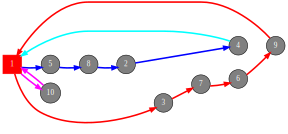

In [19]:
soled=qsol.get_value_dict(qx)
for key in soled:
    if soled[key] == 0:
        A.delete_edges_from(edgelist[key-1])
A.draw("scopt.svg")  # write to file
from IPython.display import SVG
SVG('scopt.svg')



Note that, as expected, the optimal solution is the same as the one obtained by `cplex` on the original problem. The problem however is `NP-hard` and we can't expect an easy solution for larger instances. 

### Solving the exact set cover problem with a quantum algorithm

Since our model has a linear objective function, binary variable and equality constraints, `qiskit` can convert the `docplex` created model to an Ising Hamiltonian as follows

In [20]:
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer


qp=from_docplex_mp(qmdl)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

Here we have executed the following steps:
* Convert the integer program to a quadratic. 
* Use the quadratic to QUBO converter. 
* Use the `to_ising()` method to get the Hamiltonian.

The generated Hamiltonian is

In [21]:
print(offset,'\n',str(qubitOp))

1568.5457777777763 
 -33.8307611111112 * IIIIZ
- 32.36388333333329 * IIIZI
+ 133.20450555555556 * IIZII
- 32.25173888888878 * IZIII
- 34.25812222222203 * ZIIII
+ 156.9045777777777 * IZIIZ
+ 470.71373333333304 * IZIZI
+ 470.71373333333304 * ZIIIZ
+ 156.9045777777777 * ZIIZI


We can use the `NumPyMinimumEigensolver` to solve it classically.

In [22]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result)

fval=179.78943333333245, route_1=1.0, route_2=1.0, route_3=1.0, route_4=0.0, route_5=0.0, status=SUCCESS


We see that the solution is correct, i.e., it matches the optimal solution produced by `cplex` on the integer programming formulation of the problem. 

Next, we will run the optimization of the Hamiltonian on a quantum simulator using the QAOA algorithm. The solution produced is the optimal one (same as found before). Note that the simulator runs pretty fast given that we have a small problem with 5 variables (routes). As the number of variables increases this will take longer (it runs over an hour with 10 variables) and eventually will become too much for the simulator to handle.

In [23]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
algorithm_globals.random_seed = 10598

sampler = Sampler(options={
    'seed_simulator': algorithm_globals.random_seed,
    'seed_transpiler': algorithm_globals.random_seed
})

qaoa_mes = QAOA(sampler=sampler, initial_point=[0., 0.])
exact_mes = NumPyMinimumEigensolver()
qaoa = MinimumEigenOptimizer(qaoa_mes)  
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)





fval=179.78943333333245, route_1=1.0, route_2=1.0, route_3=1.0, route_4=0.0, route_5=0.0, status=SUCCESS


<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>